In [1]:
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.algorithms.preprocessing.distributional_repair import DistributionalRepair
from aif360.algorithms.preprocessing.pointwise_repair import PointwiseRepair

from aif360.datasets import AdultDataset
import numpy as np
import pandas as pd
import ot
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

C:\Users\01joh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
def load_adult_dataset(s,u,x,y):
    def custom_preprocessing(df):
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        #drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

In [3]:
def eval_labels(Y, S, S_set=[0,1]):
    eval_dict = {}
    eval_dict['di'] = np.sum(Y[S == S_set[0]]) / np.sum(Y[S == S_set[1]])
    return eval_dict

def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)
    kde_0 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_0.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support)) 
    #add a small value to avoid division by zero
    pmf_0 += 1e-10
    kde_1 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_1.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))
    pmf_1 += 1e-10
    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        mask_0 = np.asarray((u == u_val) & (s == 0))
        mask_1 = np.asarray((u == u_val) & (s == 1))
        if (np.sum(mask_0) == 0) or (np.sum(mask_1) == 0):
            continue
        tmp = _eval_kld(x[mask_0].values, x[mask_1].values)
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)
    return tot_kld

In [5]:
n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated pdfs

s = 'sex'
u = 'college_educated'
x = ['age','education-num','hours-per-week']
y = 'Income Binary'

continuous_features = ['age','hours-per-week']
# continuous_features = ['age','hours-per-week','education-num']

data = load_adult_dataset(s,u,x,y)
data_R, data_A = data.split([n_R], shuffle=False)

C:\Users\01joh\AppData\Local\Temp\ipykernel_40396\2542293367.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)


In [6]:
d = DistributionalRepair(s, u, x, y, continuous_features, n_q)
# dataset_R_repaired, dataset_A_repaired = d.fit_transform(dataset_R, dataset_A)
dataset_R_repaired, dataset_A_repaired = d.fit_transform(data_R, data_A)

In [7]:
tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][x]
tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][x]

In [8]:
p = PointwiseRepair(s, u, x, y)
dataset_R_repaired_pt = p.fit_transform(data_R)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\01joh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


In [9]:
tilde_x_R_pt = dataset_R_repaired_pt.convert_to_dataframe()[0][x]

In [10]:
feats = d.x_R.columns
print(feats)

Index(['age', 'education-num', 'hours-per-week'], dtype='object')


In [11]:
kld_x = np.zeros(shape=(len(feats), 2))
kld_x_tilde = np.zeros(shape=(len(feats), 2))
kld_x_tilde_pt = np.zeros(shape=(len(feats), 2))

pos = np.arange(len(feats))

for i, feat in enumerate(feats):
    kld_x[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
    kld_x[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
    kld_x_tilde[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
    kld_x_tilde[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
    kld_x_tilde_pt[i, 0] = eval_kld(tilde_x_R_pt[feat], d.s_R, d.u_R, order=[0, 1])
    kld_x_tilde_pt[i, 1] = eval_kld(tilde_x_R_pt[feat], d.s_R, d.u_R, order=[1, 0])
    


[0.58921901 0.9108522  1.25029743]
[0.24892096 3.34723004 0.33800154]
[1.63238036 2.45239936 2.0487056 ]


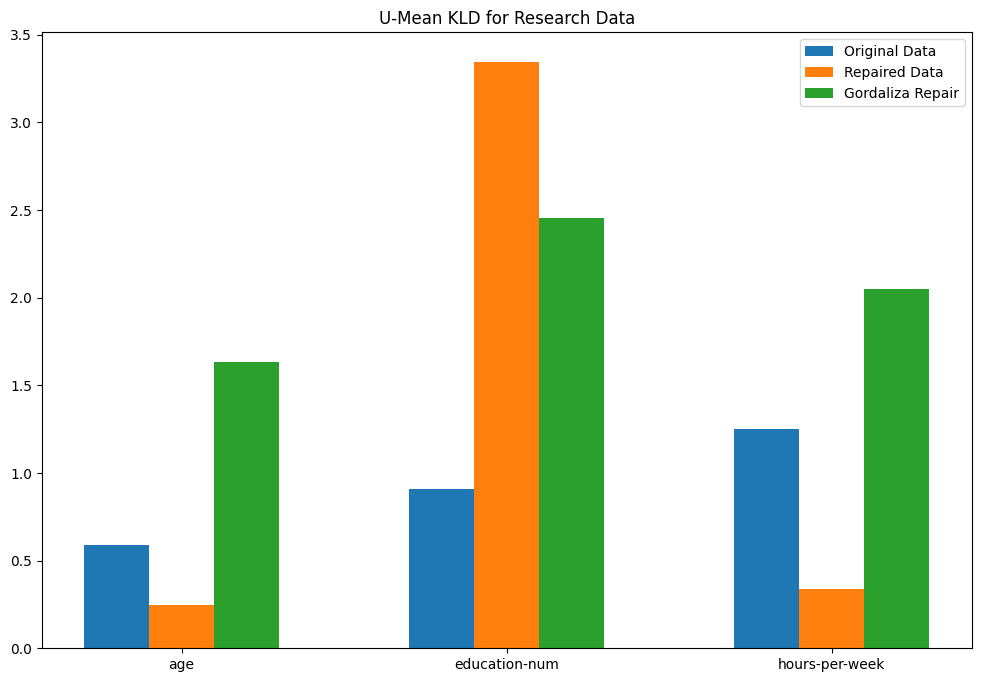

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2

ax.bar(x=pos - bar_width, height=np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))), width=bar_width, alpha=1, label='Original Data')
ax.bar(x=pos, height=np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))), width=bar_width, alpha=1, label='Repaired Data')
ax.bar(x=pos + bar_width, height=np.mean(kld_x_tilde_pt, axis=1, where=~(np.isinf(kld_x_tilde_pt))), width=bar_width, alpha=1, label='Gordaliza Repair')

ax.set_xticks(pos)
ax.set_xticklabels(feats)
ax.set_title('U-Mean KLD for Research Data')
ax.legend()

print(np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))))
print(np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))))
print(np.mean(kld_x_tilde_pt, axis=1, where=~(np.isinf(kld_x_tilde_pt))))

In [13]:
kld_x = np.zeros(shape=(len(feats), 2))
kld_x_tilde = np.zeros(shape=(len(feats), 2))

pos = np.arange(len(feats))

for i, feat in enumerate(feats):
    kld_x[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][x][feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][x][feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_tilde[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_tilde[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[1, 0])


[0.53333975 0.5596311  1.11492956]
[0.51017853 3.11337193 0.26928241]


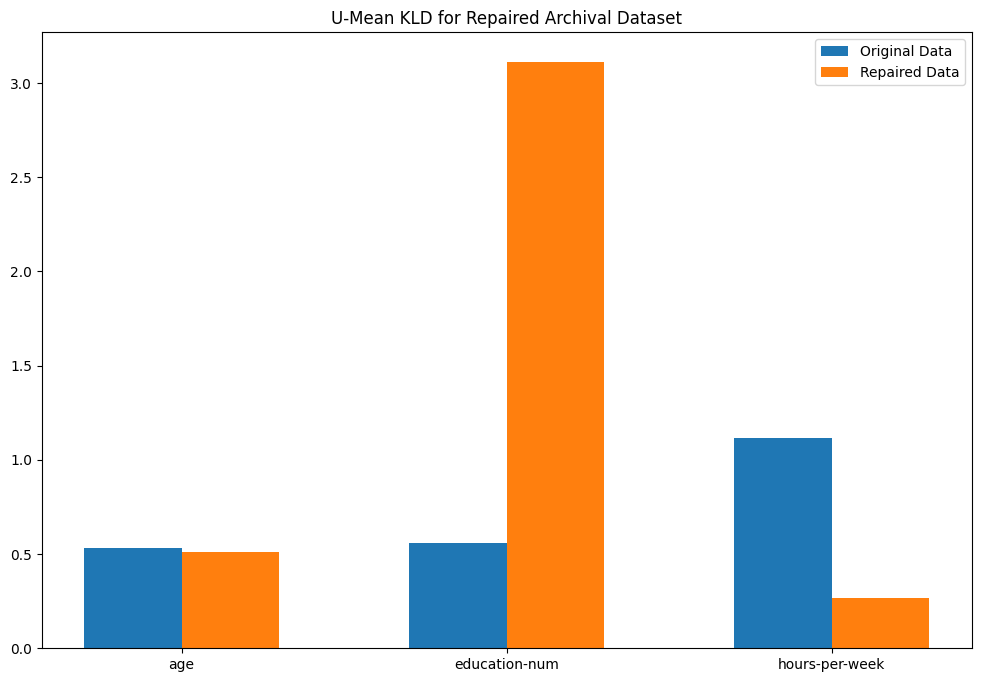

In [14]:

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.3
ax.bar(x=pos - bar_width/2, height=np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))), width=bar_width, alpha=1, label='Original Data')
ax.bar(x=pos + bar_width/2, height=np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))), width=bar_width, alpha=1, label='Repaired Data')

ax.set_xticks(pos)
ax.set_xticklabels(feats)
ax.set_title('U-Mean KLD for Repaired Archival Dataset')
ax.legend()

print(np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))))
print(np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))))